# Start-to-Finish Example: Setting up Spinning, UIUC Black Hole Initial Data, in Curvilinear Coordinates

## This module sets up initial data for a spinning black hole in *spherical coordinates*, using the *Numerical* ADM Spherical to BSSN Curvilinear initial data module (numerical = BSSN $\lambda^i$'s are computed using finite-difference derivatives instead of exact expressions).

<font color='green'>**This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see plot at bottom), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy).**</font>

### NRPy+ Source Code for this module: 
1. [BSSN/UIUCBlackHole.py](../edit/BSSN/UIUCBlackHole.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-UIUCBlackHole.ipynb): UIUC Black Hole initial data; sets all ADM variables in Spherical basis: 
1. [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
1. [BSSN/BSSN_Constraints.py](../edit/BSSN/BSSNConstraints.py); [\[**tutorial**\]](Tutorial-BSSNConstraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

Here we use NRPy+ to generate initial data for a single spinning black hole (UIUC black hole, [Liu, Etienne, & Shapiro, PRD 80 121503, 2009](https://arxiv.org/abs/1001.4077)).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data (**This module**).</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. <font color='green'>Apply constraints on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$</font>
1. At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>.
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

## Set core NRPy+ parameters for numerical grids and reference metric

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Spherical")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# We will need the h_{ij} quantities defined within BSSN_RHSs 
#    below when we enforce the gammahat=gammabar constraint
import BSSN.BSSN_RHSs as rhs
rhs.BSSN_RHSs()

#################
# Next output C headers related to the numerical grids we just set up:
#################

# First output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")

# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN/xxCart.h")

# Register the Hamiltonian as a gridfunction, to be used later.
H = gri.register_gridfunctions("AUX","H")

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Wrote to file "BSSN/xxCart.h"


## Import UIUC Black Hole ADM initial data C function from the [BSSN.UIUCBlackHole](../edit/BSSN/UIUCBlackHole.py) NRPy+ module

The [BSSN.UIUCBlackHole](../edit/BSSN/UIUCBlackHole.py) NRPy+ module does the following:

1. Set up UIUC black hole initial data, represented by [ADM](https://en.wikipedia.org/wiki/ADM_formalism) quantities in the **Spherical basis**, as [documented here](Tutorial-ADM_Initial_Data-UIUCBlackHoleipynb). 
1. Convert the numerical ADM **Spherical quantities** to **BSSN quantities in the desired Curvilinear basis** (set by reference_metric::CoordSystem), as [documented here](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).
1. Sets up the standardized C function for setting all BSSN Curvilinear gridfunctions in a pointwise fashion, as [written here](../edit/BSSN/BSSN_ID_function_string.py), and returns the C function as a Python string.

In [2]:
# Import UIUC Black Hole initial data
import BSSN.UIUCBlackHole as uibh
uibh.UIUCBlackHole(ComputeADMGlobalsOnly=True)

with open("BSSN/ID_ADM_SphorCart.h", "w") as file:
    file.write("""
// This function takes as input either (x,y,z) or (r,th,ph) and outputs
//   all ADM quantities in the Cartesian or Spherical basis, respectively.
void ID_ADM_SphorCart(const REAL xyz_or_rthph[3], 
                     REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                     REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                     REAL *alpha,
                     REAL *betaU0,REAL *betaU1,REAL *betaU2,
                     REAL *BU0,REAL *BU1,REAL *BU2) {
      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];\n""")
outCparams = "preindent=1,outCfileaccess=a,outCverbose=False,includebraces=False"
outputC([uibh.gammaSphDD[0][0],uibh.gammaSphDD[0][1],uibh.gammaSphDD[0][2],
           uibh.gammaSphDD[1][1],uibh.gammaSphDD[1][2],uibh.gammaSphDD[2][2],
           uibh.KSphDD[0][0],uibh.KSphDD[0][1],uibh.KSphDD[0][2],
           uibh.KSphDD[1][1],uibh.KSphDD[1][2],uibh.KSphDD[2][2],
           uibh.alphaSph, uibh.betaSphU[0],uibh.betaSphU[1],uibh.betaSphU[2],
           uibh.BSphU[0],uibh.BSphU[1],uibh.BSphU[2]],
        ["*gammaDD00","*gammaDD01","*gammaDD02","*gammaDD11","*gammaDD12","*gammaDD22",
         "*KDD00","*KDD01","*KDD02","*KDD11","*KDD12","*KDD22",
         "*alpha","*betaU0","*betaU1","*betaU2","*BU0","*BU1","*BU2"],
        "BSSN/ID_ADM_SphorCart.h",params=outCparams)
with open("BSSN/ID_ADM_SphorCart.h", "a") as file:
    file.write("}\n")

import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_ADM_SphorCart")

Appended to file "BSSN/ID_ADM_SphorCart.h"
Appended to file "BSSN/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
Appended to file "BSSN/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"


## Apply singular, curvilinear coordinate boundary conditions [as documented in the NRPy+ tutorial module](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

After setting the gridfunctions to their initial values, we must next apply boundary conditions, as initial data are sometimes ill-defined in ghost zones. E.g., spherical initial data might not be properly defined at points where r=-1.

Admittedly this is not as much a concern with initial data originally defined in a Cartesian basis. Applying these boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint.

In [3]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions()

Wrote to file "CurviBoundaryConditions/set_parity_conditions.h"
Wrote to file "CurviBoundaryConditions/xxCart.h"
Wrote to file "CurviBoundaryConditions/Cart_to_xx.h"


## Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658))

As mentioned in the [BSSN curvilinear tutorial module](Tutorial-BSSNCurvilinear.ipynb), the adopted formulation of Einstein's equations requires that $\partial_t \bar{\gamma} = 0$, where $\bar{\gamma}=\det \bar{\gamma}_{ij}$. Further, all initial data we choose satisfies $\bar{\gamma}=\hat{\gamma}$. 

However, numerical errors will cause $\bar{\gamma}$ to deviate from a constant in time. This actually disrupts the hyperbolicity of the PDEs, so to cure this, we adjust $\bar{\gamma}_{ij}$ at the end of each Runge-Kutta timestep, so that its determinant satisfies $\bar{\gamma}=\hat{\gamma}$ at all times. We adopt the following, rather standard prescription (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)):

$$
\bar{\gamma}_{ij} \to \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij}.
$$
Notice the expression on the right is guaranteed to have determinant equal to $\hat{\gamma}$.

Unfortunately $\bar{\gamma}_{ij}$ is not an evolved variable, so we must rewrite the above in terms of $h_{ij}$:
\begin{align}
\left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij} &= \bar{\gamma}'_{ij}  \\
&= \hat{\gamma}_{ij} + \varepsilon'_{ij} \\
&= \hat{\gamma}_{ij} + \text{Re[i][j]} h'_{ij} \\
\implies h'_{ij} &= \left[\left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij} - \hat{\gamma}_{ij}\right] / \text{Re[i][j]} \\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \frac{\bar{\gamma}_{ij}}{\text{Re[i][j]}} - \delta_{ij}\\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \frac{\hat{\gamma}_{ij} + \text{Re[i][j]} h_{ij}}{\text{Re[i][j]}} - \delta_{ij}\\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \left(\delta_{ij} + h_{ij}\right) - \delta_{ij}
\end{align}

Upon inspection, when expressing $\hat{\gamma}$ SymPy generates expressions like $\text{(xx0)}^{4/3}=\text{pow(xx0, 4./3.)}$, which can yield $\text{NaN}$s when $\text{xx0}<0$ (i.e., in the $\text{xx0}$ ghost zones). To prevent this, we know that $\hat{\gamma}\ge 0$ for all reasonable coordinate systems, so we make the replacement $\hat{\gamma}\to |\hat{\gamma}|$ below:

In [4]:
# First define the Kronecker delta:
KroneckerDeltaDD = ixp.zerorank2()
for i in range(DIM):
    KroneckerDeltaDD[i][i] = sp.sympify(1)

# The detgammabar in BSSN_RHSs is set to detgammahat when BSSN_RHSs::detgbarOverdetghat_equals_one=True (default),
#    so we manually compute it here:
dummygammabarUU, detgammabar = ixp.symm_matrix_inverter3x3(rhs.gammabarDD)

# Next apply the constraint enforcement equation above.
hprimeDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        hprimeDD[i][j] = \
        (sp.Abs(rfm.detgammahat)/detgammabar)**(sp.Rational(1,3)) * (KroneckerDeltaDD[i][j] + rhs.hDD[i][j]) \
        - KroneckerDeltaDD[i][j]

enforce_detg_constraint_vars = [ \
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD00"),rhs=hprimeDD[0][0]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD01"),rhs=hprimeDD[0][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD02"),rhs=hprimeDD[0][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD11"),rhs=hprimeDD[1][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD12"),rhs=hprimeDD[1][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD22"),rhs=hprimeDD[2][2]) ]

enforce_gammadet_string = fin.FD_outputC("returnstring",enforce_detg_constraint_vars,
                                         params="outCverbose=False,preindent=0,includebraces=False")

with open("BSSN/enforce_detgammabar_constraint.h", "w") as file:
    indent = "   "
    file.write("void enforce_detgammabar_constraint(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {\n\n")
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],
                       ["1","1","1"],["#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+enforce_gammadet_string))
    file.write("}\n")

## Validate that the UIUC black hole initial data satisfy the Hamiltonian constraint, modulo numerical finite differencing error

### First output the Hamiltonian constraint:

In [5]:
from outputC import *
import grid as gri
import BSSN.BSSNConstraints as bssncon
bssncon.BSSNConstraints()

import time
start = time.time()
Hamiltonianstring = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs","H"),rhs=bssncon.H), 
                                   params="outCverbose=False")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

import loop as lp
with open("BSSN/Hamiltonian.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+Hamiltonianstring))

Finished in 12.4543571472 seconds.


# UIUCBlackHole_Playground.c: The Main C Code

In [6]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN/NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost zones, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # Upwinding in BSSN requires that NGHOSTS = FD_CENTDERIVS_ORDER/2 + 1 <- Notice the +1.
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2)+1)+"\n")

In [7]:
%%writefile BSSN/UIUCBlackHole_Playground.c

// Part P1: Import needed header files
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Part P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters for the numerical grid
const REAL xmin = -10.,xmax=10.;
const REAL ymin = -10.,ymax=10.;
const REAL zmin = -10.,zmax=10.;

const REAL RMAX    = 5.0;
const REAL AMPL    = 5.0;
const REAL SINHW   = 0.125;
const REAL t_final =  8.0; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
const REAL CFL_FACTOR = 1.0; // Set the CFL Factor

// Step P4: Set free parameters for the (UIUC black hole) initial data
const REAL M   = 1.0;
const REAL chi = 0.8;

// Part P4b: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Part P4c: Set #define's for BSSN gridfunctions. C code generated above
#include "../CurviBoundaryConditions/gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

// Step P5: Function for converting uniform grid coord 
//         (xx[0][i0],xx[1][i1],xx[2][i2]) to 
//          corresponding Cartesian coordinate.
void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "../CurviBoundaryConditions/curvilinear_parity_and_outer_boundary_conditions.h"

// Step P7: Function for enforcing the gammabar=gammahat constraint:
#include "enforce_detgammabar_constraint.h"

// Part P8: Declare all functions for setting up UIUC initial data.
#include "ID_ADM_SphorCart.h"
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"
    
// Part P9: Declare function for computing the Hamiltonian
//           constraint violation, which should converge to
//           zero with increasing numerical resolution.
void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 4 || atoi(argv[1]) < NGHOSTS) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./UIUCBlackHole_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nx0 = atoi(argv[1]);
    const int Nx1 = atoi(argv[2]);
    const int Nx2 = atoi(argv[3]);
    if(Nx0%2 != 0 || Nx1%2 != 0 || Nx2%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx[3] = { Nx0, Nx1, Nx2 };
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    // Step 0c: Allocate memory for gridfunctions
    REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0e: Find ghostzone mappings and parities:
    gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
    parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
    set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

    // Step 1: Set up initial data to an exact solution at time=0:
    ID_BSSN__ALL_BUT_LAMBDAs(Nxx_plus_2NGHOSTS,xx, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
    ID_BSSN_lambdas(Nxx, Nxx_plus_2NGHOSTS, xx,dxx, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

    // Step 1b: Apply boundary conditions, as initial data 
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
//    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
//    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
        
    // Step 2: Evaluate Hamiltonian constraint violation
    Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

    /* Step 3: Output relative error between numerical and exact solution, */
    const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
    const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
    const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
    LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, i1mid,i1mid+1, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
        REAL xx0 = xx[0][i0];
        REAL xx1 = xx[1][i1];
        REAL xx2 = xx[2][i2];
        REAL xCart[3];
#include "xxCart.h"
        int idx = IDX3(i0,i1,i2);
        printf("%e %e %e %e\n",xCart[0],xCart[1], evol_gfs[IDX4pt(CFGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
        //     printf("%e %e %e %e %e %e %e %e %e\n",xCart[0],xCart[1],xCart[2], aux_gfs[IDX4pt(HGF,idx)],evol_gfs[IDX4pt(CFGF,idx)],
        //            evol_gfs[IDX4pt(ALPHAGF,idx)],evol_gfs[IDX4pt(VETU0GF,idx)],evol_gfs[IDX4pt(HDD00GF,idx)],
        //            evol_gfs[IDX4pt(LAMBDAU0GF,idx)]);
    }

    /* Step 4: Free all allocated memory */
    free(aux_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting BSSN/UIUCBlackHole_Playground.c


In [8]:
!cd BSSN/
!rm -f UIUCBlackHole_Playground
!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp BSSN/UIUCBlackHole_Playground.c -o UIUCBlackHole_Playground -lm
!taskset -c 0,1 ./UIUCBlackHole_Playground 96 96 96 > out96.txt

## Now plot the single-black-hole initial data

Here we plot the evolved conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the single black holes centered at the origin: $x/M=y/M=z/M=0$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

In [9]:
!pip install scipy > /dev/null

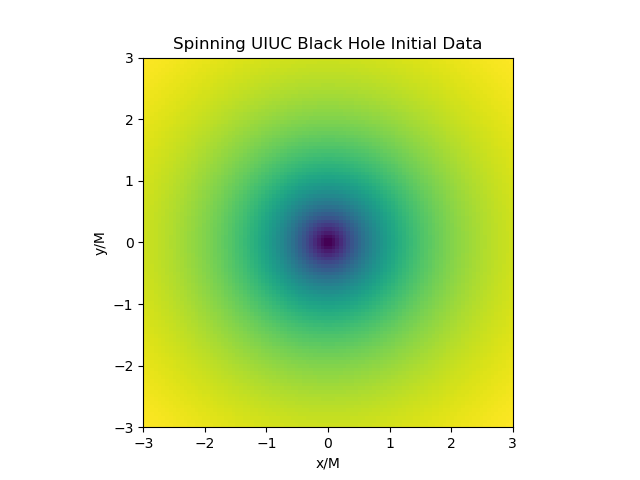

In [10]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

x96,y96,valuesCF96,valuesHam96 = np.loadtxt('out96.txt').T #Transposed for easier unpacking


pl_xmin = -3.
pl_xmax = +3.
pl_ymin = -3.
pl_ymax = +3.

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((len(x96), 2))
for i in range(len(x96)):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

plt.clf()
plt.title("Spinning UIUC Black Hole Initial Data")
plt.xlabel("x/M")
plt.ylabel("y/M")

# fig, ax = plt.subplots()
# ax.plot(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
# plt.close(fig)
plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
savefig("BHB.png")
from IPython.display import Image
Image("BHB.png")
# #           interpolation='nearest', cmap=cm.gist_rainbow)

## Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

First, let's take a look at what the numerical error looks like on the x-y plane at a given numerical resolution, plotting $\log_{10}|H|$, where $H$ is the Hamiltonian constraint violation:

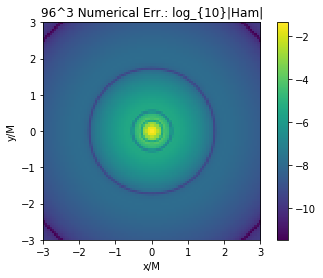

In [11]:
grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next, we set up the same initial data but on a lower-resolution, $48^3$ grid. Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96^3$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected. I.e., at all points *except* at the points immediately surrounding the coordinate center of the black hole (due to the spatial slice excising the physical singularity at this point through [the puncture method](http://gr.physics.ncsu.edu/UMD_June09.pdf)) exhibit numerical errors that drop as $\left(\Delta x^i\right)^4$.

<Figure size 432x288 with 0 Axes>

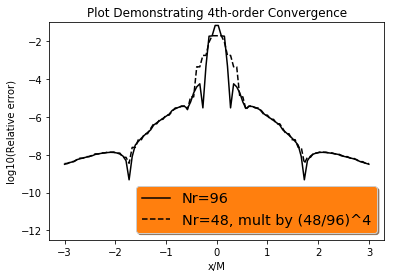

In [12]:
!taskset -c 0,1 ./UIUCBlackHole_Playground 48 48 48 > out48.txt

x48,y48,valuesCF48,valuesHam48 = np.loadtxt('out48.txt').T #Transposed for easier unpacking
points48 = np.zeros((len(x48), 2))
for i in range(len(x48)):
    points48[i][0] = x48[i]
    points48[i][1] = y48[i]

grid48 = griddata(points48, valuesHam48, (grid_x, grid_y), method='nearest')

griddiff_48_minus_96 = np.zeros((100,100))
griddiff_48_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid48_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff_48_minus_96[i][j] = grid48[i][j] - grid96[i][j]
        griddiff_48_minus_96_1darray[count] = griddiff_48_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid48_1darray_yeq0[i] = grid48[i][j] + np.log10((48./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid48_1darray_yeq0, 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-12.5,-1.])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()